# Twitter Data EDA

The data is collected using the following key words

- inflation
- fuelprice
- fuelpricehike
-  fuelprices
- fuelshortage
- foodprice
-  oilprice
- oilprices
- cookingoilprice
- unemployment
- unemploymentrate
- economiccrisis
- economichardship

---

* our goal is to Explore the data for two machine learning tasks
1. Topic modeling
2. Sentiment Analysis

##  Imports

In [1]:
# extrenal modules
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import numpy as np
import os
import sys
import json
from collections import Counter
cwd = os.getcwd()
parent = cwd.replace('/notebooks', '')
sys.path.insert(0, parent) 

from clean_tweets_dataframe import CleanTweets
from extract_dataframe import read_json, TweetDfExtractor
from utils import DataLoader
from tweets_preprocess import SADataPreparation

rcParams['figure.figsize'] = (12, 7)
%matplotlib inline

## Data Fetch

We already have a data transformation module (Data Consistency module) `extract_dataframe`
That will be used to Transform the JSON data into a pandas dataframe.
If this step is already run, it would simply read a CSV that it cached 
on the previous run.

In [2]:
filename = 'processed_tweet_data.csv'
loader = DataLoader('../', filename)
tweet_df = loader.read_csv()

* As we can see, there are lots of missing values and columns with the wrong datatypes. We have the Clean_Tweets class to handle this for us. 

In [3]:
tweet_df.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Apr 22 22:20:18 +0000 2022,Twitter for Android,RT @nikitheblogger: Irre: Annalena Baerbock sa...,0.0,0.0,de,0,355.0,McMc74078966,3,12,NaN,[],['nikitheblogger'],NaN
1,Fri Apr 22 22:19:16 +0000 2022,Twitter for Android,RT @sagt_mit: Merkel schaffte es in 1 Jahr 1 M...,0.0,0.0,de,0,505.0,McMc74078966,3,12,NaN,[],['sagt_mit'],NaN
2,Fri Apr 22 22:17:28 +0000 2022,Twitter for Android,RT @Kryptonoun: @WRi007 Pharma in Lebensmittel...,0.0,0.0,de,0,4.0,McMc74078966,3,12,NaN,[],"['Kryptonoun', 'WRi007']",NaN
3,Fri Apr 22 22:17:20 +0000 2022,Twitter for Android,RT @WRi007: Die #Deutschen sind ein braves Vol...,0.0,0.0,de,0,332.0,McMc74078966,3,12,NaN,"['Deutschen', 'Spritpreisen', 'inflation', 'Ab...",['WRi007'],NaN
4,Fri Apr 22 22:13:15 +0000 2022,Twitter for Android,RT @RolandTichy: Baerbock verkündet mal so neb...,0.0,0.0,de,0,386.0,McMc74078966,3,12,NaN,[],['RolandTichy'],NaN


### Missing entries

- Count total missing value
- See which columns have missing values
- Plot the number of missing values in columns

In [4]:
missing_count = tweet_df.isnull().sum()
# cols_with_missing = tweet_df.columns[tweet_df.isnull().any()]

print(f"Missing value(s) count: \n{missing_count}")
# print(f"Columns having missing value(s): {cols_with_missing}")

Missing value(s) count: 
created_at                0
source                    4
original_text             4
polarity                 12
subjectivity             12
lang                     12
favorite_count           12
retweet_count            12
original_author          12
followers_count          19
friends_count            12
possibly_sensitive    14655
hashtags                 13
user_mentions            20
place                  8913
dtype: int64


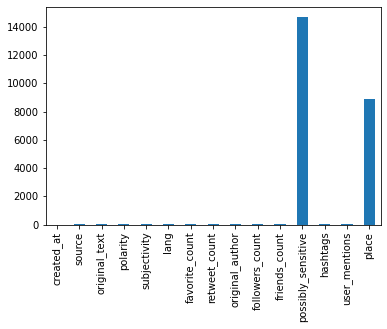

In [5]:
fig = missing_count.plot(kind='bar', fontsize=10).get_figure()
fig.savefig("missing_values_bar_chart.png")

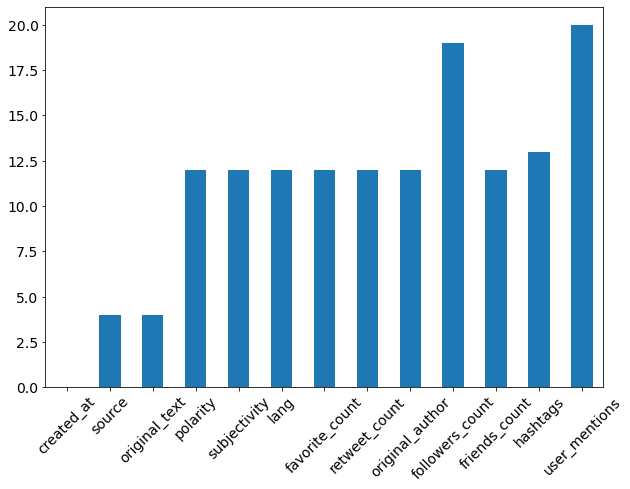

In [6]:
copy_missing_count = missing_count.copy()
copy_missing_count= copy_missing_count.drop(labels=['place', 'possibly_sensitive'])
fig = copy_missing_count.plot(kind='bar', fontsize=14, figsize=(10, 7), rot=45).get_figure()
fig.savefig("missing_values_bar_chart_with_drop.png")

In [7]:
cleaner = CleanTweets()
cleaned_df = cleaner.run_pipeline(tweet_df)

Automation in Action...!!!


In [8]:
pprocessor = SADataPreparation()
labled_df = pprocessor.preprocess_data(cleaned_df)
labled_df.columns

Pre-Processing the Tweets


Index(['created_at', 'source', 'original_text', 'polarity', 'subjectivity',
       'lang', 'favorite_count', 'retweet_count', 'original_author',
       'followers_count', 'friends_count', 'possibly_sensitive', 'hashtags',
       'user_mentions', 'place', 'score'],
      dtype='object')

As we can see above we hace a new column with the lables named score

In [9]:
labled_df[['original_text', 'score']].tail()

,original_text,score
2213,PFI's statement over my anti-conversion remark...,negative
2214,"#Ahmedabad,Gujarat | I've no plans to join #BJ...",positive
2215,"RT @nitinagarwalINC: Love is strength, \nHate...",negative
2216,RT @drshamamohd: Zoya Charitable Trust distrib...,positive
2217,Thank you @BajpayeeManoj ji for this beautiful...,positive


# Positive Vs Negative Sentiments

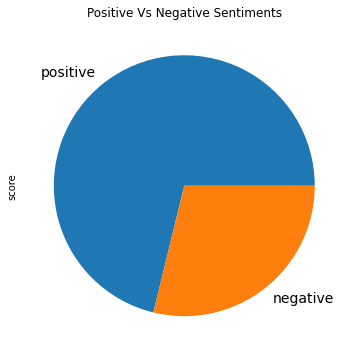

In [10]:
fig = labled_df['score'].value_counts().plot.pie(figsize=(6, 6), fontsize=14, title="Positive Vs Negative Sentiments").get_figure()
fig.savefig("pos_vs_neg.png")

In [11]:
cleaned_df.sort_values('created_at', ascending=True, inplace=True, ignore_index=True)
cleaned_df.loc[0, 'created_at'], cleaned_df.loc[len(cleaned_df)-1, 'created_at']

(Timestamp('2021-01-07 04:30:23+0000', tz='UTC'),
 Timestamp('2022-04-22 23:07:15+0000', tz='UTC'))

The timeline for the data we have is between 07-Jan-2021 upto 22-Apr-2022

# Common hashtags

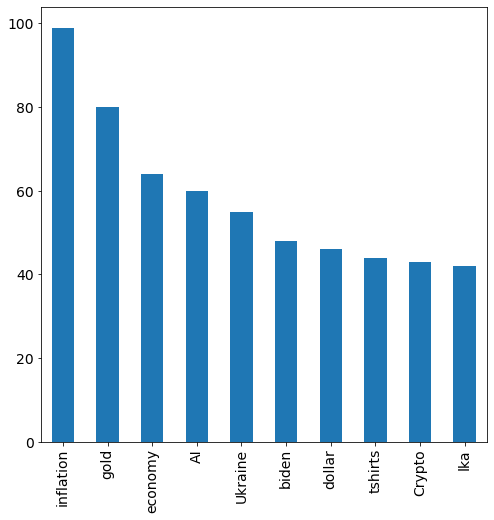

In [12]:
hashtags = cleaned_df['hashtags'].map(np.array).values
all_hashtags = []
for hashtag in hashtags:
    hashtag = hashtag.strip("][").split(",")
    all_hashtags += hashtag

all_hashtags = list(map(lambda s: s.replace(' \'', '').strip("'").strip(), all_hashtags)) 
from collections import Counter
hashtags_count = {**Counter(all_hashtags)}
# There is a blank entry with 2342 counts. I will remove that
hashtags_count = {key:val for key, val in hashtags_count.items() if val != 2342}
hashtags_count = pd.Series(hashtags_count)
# hashtags_count.head()
fig = hashtags_count.nlargest(10).plot.bar(figsize=(8, 8), fontsize=14).get_figure()
fig.savefig("common_hashtags.png")
# hashtags_count.nlargest()
# hashtags_count.shape

# Users Analysis

Here we will see, user specific details like:

* The total number of users in the dataset
* The number of tweets per users
* Users with the most liked, shared tweets
* The sentiment of the tweets with the most interactions (likes and retweets)

The main take away from this section is to see if tweets with posetive or negative sentiments are getting more interactions

In [13]:
users_count = cleaned_df['original_author'].value_counts()
print(len(users_count), "users")
print("Number of posts per user")
users_count.nlargest(5)

272 users
Number of posts per user


lineappofficial    50
MirrorNow          50
ASBrokerage        50
Maxi_Group_LLC     50
pastexpiry         50
Name: original_author, dtype: int64

Now, for the part about interactions with tweets

<AxesSubplot:ylabel='Frequency'>

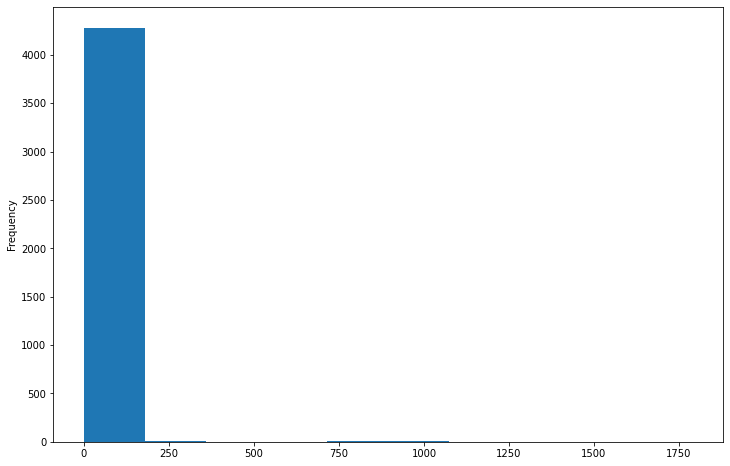

In [14]:
cleaned_df['favorite_count'].plot.hist(figsize=(12, 8))

***There are lot's of tweets withe 0 to 200 likes, which is why our plot is not showing the rest. Let's take only the tweets with likes>200***

<AxesSubplot:ylabel='Frequency'>

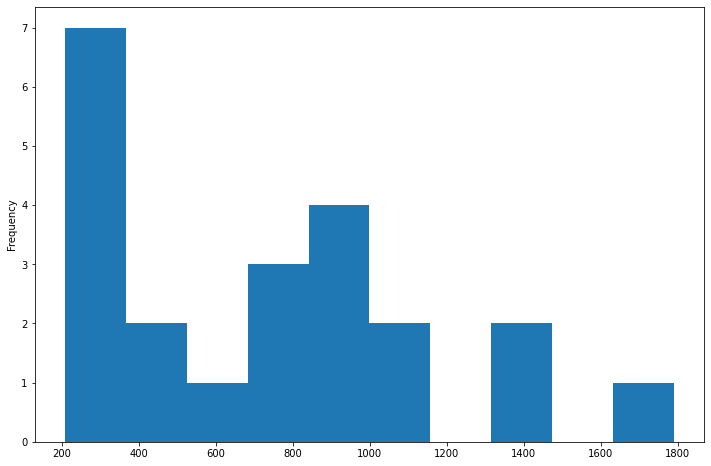

In [15]:
hot_tweets = cleaned_df[cleaned_df['favorite_count']>200]
hot_tweets['favorite_count'].plot.hist(figsize=(12, 8))

In [16]:
# Histogram showing the trend in the number of likes (favourites)


### Tweet Sources 

<AxesSubplot:>

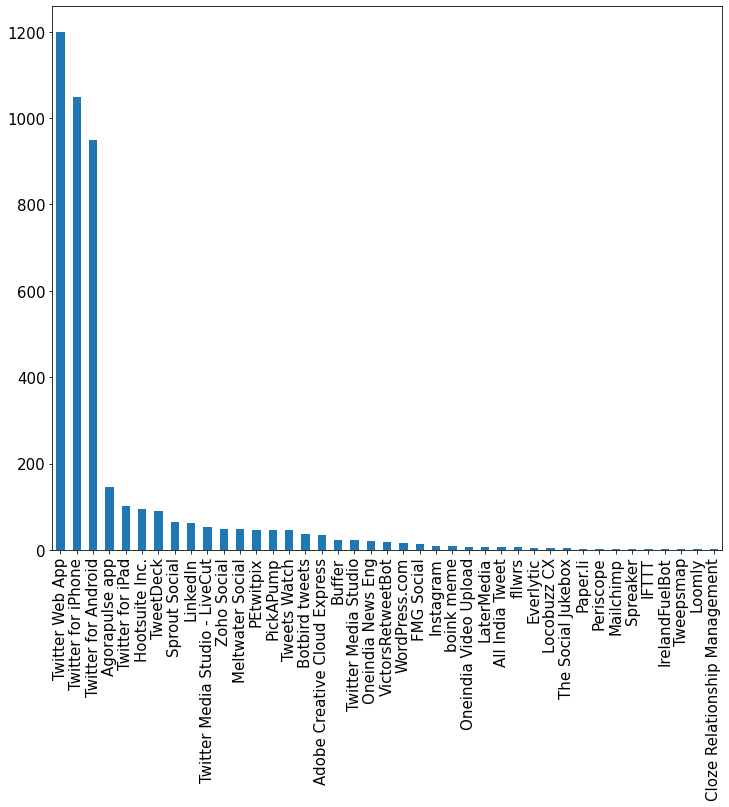

In [21]:
cleaned_df['source'].value_counts().plot(kind='bar', figsize=(12, 10), fontsize=15)

<AxesSubplot:>

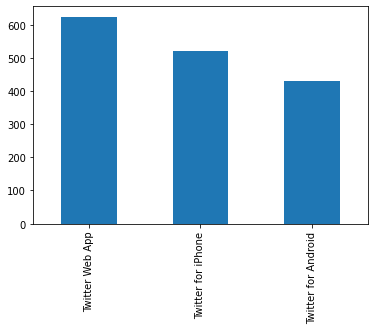

In [27]:
sources_df = labled_df[labled_df['source'].isin(["Twitter Web App", "Twitter for Android", "Twitter for iPhone"])]
web_tweets = sources_df[sources_df['source'] == "Twitter Web App"]
iphone_tweets = sources_df[sources_df['source'] == "Twitter for iPhone"]
android_tweets = sources_df[sources_df['source'] == "Twitter for Android"]
sources_df['source'].value_counts().plot.bar()

<AxesSubplot:ylabel='score'>

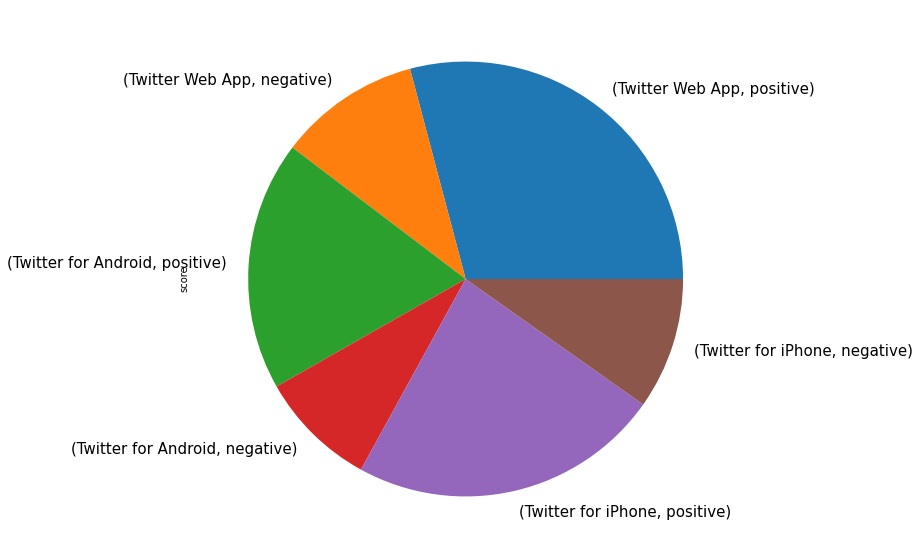

In [31]:
sources_df.groupby('source')['score'].value_counts().plot.pie(figsize=(12, 10), fontsize=15)

This shows that there are more  positive tweets than negative ones from all sources